In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(5,8,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray,(9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img,(9,6),corners,ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

In [3]:
#get distortion coefficients and camera matrix from cv2.calibrateCamera and undistort image using cv2.undistort
def cal_undistort(img,objpoints,imgpoints):
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret,mtx,dist,rvecs,tvecs=cv2.calibrateCamera(objpoints,imgpoints, gray.shape[::-1],None,None)
    undist=cv2.undistort(img,mtx,dist,None,mtx)
    return undist

In [ ]:
img=cv2.imread(images[0])
undistorted_img=cal_undistort(img,objpoints,imgpoints)
fig=plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.title('original image')
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(undistorted_img,cv2.COLOR_BGR2RGB))
plt.title('undistorted image')

In [4]:
def pipeline(img,objpoints,imgpoints,s_thresh=(170,255),sx_thresh=(20,100)):
    undistorted_img=cal_undistort(img,objpoints,imgpoints)
    
    hls_img=cv2.cvtColor(img,cv2.COLOR_BGR2HLS).astype(np.float)
    l_channel=hls_img[:,:,2]
    s_channel=hls_img[:,:,2]
    
    s_binary=np.zeros_like(s_channel)
    s_binary[(s_channel>=s_thresh[0])&(s_channel<=s_thresh[1])]=1
    
    grad_x=cv2.Sobel(l_channel,cv2.CV_64F,1, 0)
    abs_grad_x=np.absolute(grad_x)
    scaled_grad_x=np.uint8(255*abs_grad_x/np.max(abs_grad_x))
    grad_x_binary=np.zeros_like(scaled_grad_x)
    grad_x_binary[(scaled_grad_x>=sx_thresh[0])&(scaled_grad_x<=sx_thresh[1])] = 1
    
    combined_img=np.uint8(np.dstack((np.zeros_like(s_binary),s_binary,grad_x_binary))*255)
    combined_binary_img=np.zeros_like(grad_x_binary)
    combined_binary_img[(grad_x_binary==1)|(s_binary==1)]=1
    return combined_img,combined_binary_img

In [ ]:
img_path='./test_images/test2.jpg'
img=cv2.imread(img_path)
undistorted_img=cal_undistort(img,objpoints,imgpoints)
combined_img,combined_binary_img=pipeline(img,objpoints,imgpoints)

In [ ]:
fig=plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.title('original image')
plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(undistorted_img,cv2.COLOR_BGR2RGB))
plt.title('undistorted image')
plt.subplot(1,3,3)
plt.imshow(combined_img)
plt.title('combined image')
plt.figure()
plt.imshow(combined_binary_img,cmap='gray')
plt.title('combined binary image')

In [5]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [ ]:
imshape=combined_binary_img.shape
roi_vertices=np.array([[(0,imshape[0]),(imshape[1]/2-70,imshape[0]/2+90),(imshape[1]/2+70,imshape[0]/2+90),
                        (imshape[1],imshape[0])]],dtype=np.int32)
binary_roi=region_of_interest(combined_binary_img,roi_vertices)
plt.imshow(binary_roi,cmap='gray')
plt.title('region of interest mask applied')

In [ ]:
src_pts=np.float32(roi_vertices)
dst_pts=np.float32([[(200,imshape[0]),(200,0),(1080,0),(1080,imshape[0])]])
M=cv2.getPerspectiveTransform(src_pts,dst_pts)
Minv=cv2.getPerspectiveTransform(dst_pts,src_pts)
warped_binary_roi=cv2.warpPerspective(binary_roi,M,(imshape[1],imshape[0]),flags=cv2.INTER_LINEAR)
plt.imshow(warped_binary_roi,cmap='gray')
plt.title('warped region of interest')
inv_warped_binary_roi=cv2.warpPerspective(warped_binary_roi,Minv,(imshape[1],imshape[0]),flags=cv2.INTER_LINEAR)
plt.figure()
plt.imshow(inv_warped_binary_roi,cmap='gray')
plt.title('unwarped region of interest')

In [ ]:
# Take a histogram of the bottom half of the image
histogram=np.sum(warped_binary_roi[warped_binary_roi.shape[0]//2:,:],axis=0)
# Create an output image to draw on and  visualize the result
out_img=np.dstack((warped_binary_roi,warped_binary_roi,warped_binary_roi))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint=np.int(histogram.shape[0]/2)
leftx_base=np.argmax(histogram[:midpoint])
rightx_base=np.argmax(histogram[midpoint:])+midpoint

# Choose the number of sliding windows
nwindows=9
# Set height of windows
window_height=np.int(warped_binary_roi.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero=warped_binary_roi.nonzero()
nonzeroy=np.array(nonzero[0])
nonzerox=np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current=leftx_base
rightx_current=rightx_base
# Set the width of the windows +/- margin
margin=100
# Set minimum number of pixels found to recenter window
minpix=50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds=[]
right_lane_inds=[]

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low=warped_binary_roi.shape[0]-(window+1)*window_height
    win_y_high=warped_binary_roi.shape[0]-window*window_height
    win_xleft_low=leftx_current-margin
    win_xleft_high=leftx_current+margin
    win_xright_low=rightx_current-margin
    win_xright_high=rightx_current+margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0),2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0),2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

In [ ]:
# Generate x and y values for plotting
ploty = np.linspace(0, warped_binary_roi.shape[0]-1, warped_binary_roi.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [ ]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped_binary_roi).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))
# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

unwarped_out_img=cv2.warpPerspective(color_warp,Minv,(imshape[1],imshape[0]),flags=cv2.INTER_LINEAR)
result = cv2.addWeighted(undistorted_img, 1, unwarped_out_img, 0.3, 0)
plt.figure(figsize=(15,15))
plt.imshow(cv2.cvtColor(result,cv2.COLOR_BGR2RGB))
plt.title('unwarped out image')

In [6]:
def fit_lanes(warped_binary_img):
    histogram=np.sum(warped_binary_img[warped_binary_img.shape[0]//2:,:],axis=0)
    midpoint=np.int(histogram.shape[0]/2)
    leftx_base=np.argmax(histogram[:midpoint])
    rightx_base=np.argmax(histogram[midpoint:])+midpoint
    
    # Choose the number of sliding windows
    nwindows=9
    # Set height of windows
    window_height=np.int(warped_binary_img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero=warped_binary_img.nonzero()
    nonzeroy=np.array(nonzero[0])
    nonzerox=np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current=leftx_base
    rightx_current=rightx_base
    # Set the width of the windows +/- margin
    margin=100
    # Set minimum number of pixels found to recenter window
    minpix=50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds=[]
    right_lane_inds=[]

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low=warped_binary_img.shape[0]-(window+1)*window_height
        win_y_high=warped_binary_img.shape[0]-window*window_height
        win_xleft_low=leftx_current-margin
        win_xleft_high=leftx_current+margin
        win_xright_low=rightx_current-margin
        win_xright_high=rightx_current+margin
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    if leftx.size==0 or lefty.size==0:
        found_lanes=False
    else:
        found_lanes=True

    # Fit a second order polynomial to each
    left_fit=[]
    right_fit=[]
    if found_lanes:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    
    return found_lanes,left_fit,right_fit

def find_lanes(img):
    undistorted_img=cal_undistort(img,objpoints,imgpoints)
    _,combined_binary_img=pipeline(img,objpoints,imgpoints)
    
    imshape=combined_binary_img.shape
    roi_vertices=np.array([[(0,imshape[0]),(imshape[1]/2-70,imshape[0]/2+90),(imshape[1]/2+70,imshape[0]/2+90),
                            (imshape[1],imshape[0])]],dtype=np.int32)
    binary_roi=region_of_interest(combined_binary_img,roi_vertices)
    
    src_pts=np.float32(roi_vertices)
    dst_pts=np.float32([[(200,imshape[0]),(200,0),(1080,0),(1080,imshape[0])]])
    M=cv2.getPerspectiveTransform(src_pts,dst_pts)
    Minv=cv2.getPerspectiveTransform(dst_pts,src_pts)
    warped_binary_roi=cv2.warpPerspective(binary_roi,M,(imshape[1],imshape[0]),flags=cv2.INTER_LINEAR)
    
    found_lanes,left_lane_fit,right_lane_fit=fit_lanes(warped_binary_roi)
    if found_lanes:
        ploty=np.linspace(0,warped_binary_roi.shape[0]-1,warped_binary_roi.shape[0])
        left_fitx=left_lane_fit[0]*ploty**2+left_lane_fit[1]*ploty+left_lane_fit[2]
        right_fitx=right_lane_fit[0]*ploty**2+right_lane_fit[1]*ploty+right_lane_fit[2]

        warp_zero=np.zeros_like(warped_binary_roi).astype(np.uint8)
        color_warp=np.dstack((warp_zero, warp_zero,warp_zero))
        pts_left=np.array([np.transpose(np.vstack([left_fitx,ploty]))])
        pts_right=np.array([np.flipud(np.transpose(np.vstack([right_fitx,ploty])))])
        pts = np.hstack((pts_left, pts_right))
        cv2.fillPoly(color_warp,np.int_([pts]),(0,255,0))

        unwarped_out_img=cv2.warpPerspective(color_warp,Minv,(imshape[1],imshape[0]),flags=cv2.INTER_LINEAR)
        result = cv2.addWeighted(undistorted_img, 1, unwarped_out_img, 0.3, 0)
    else:
        result=undistorted_img.copy()
    return left_lane_fit,right_lane_fit,result

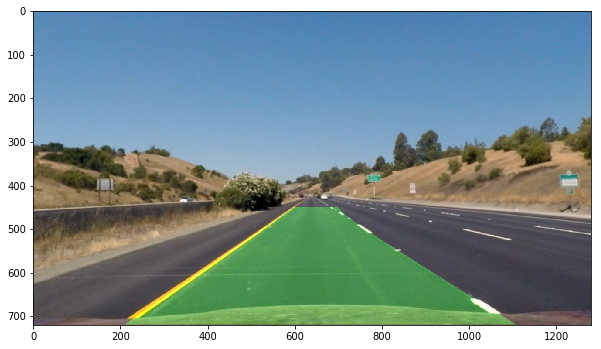

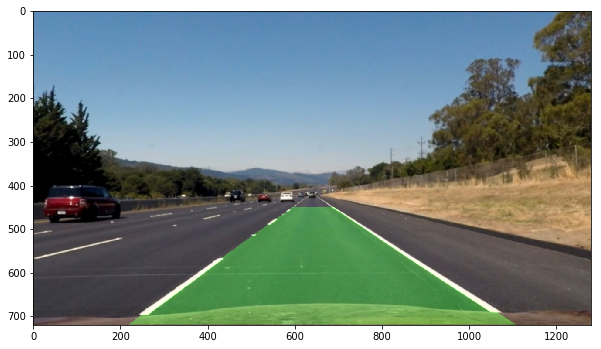

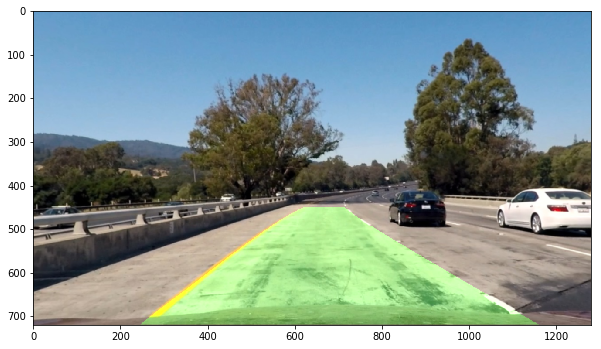

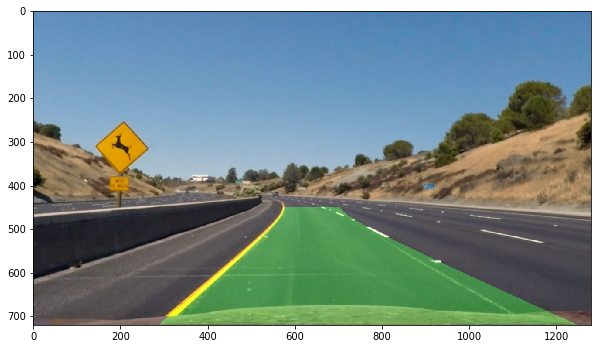

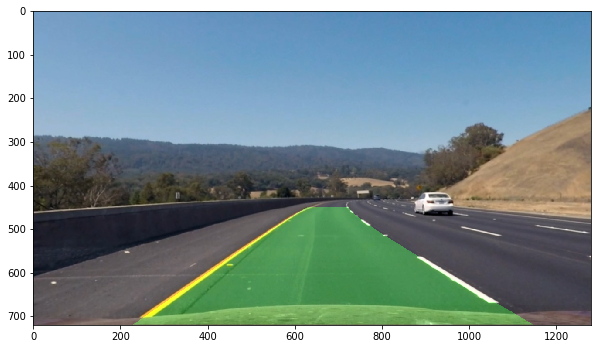

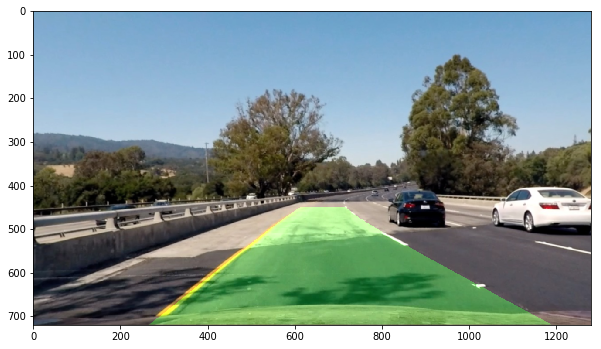

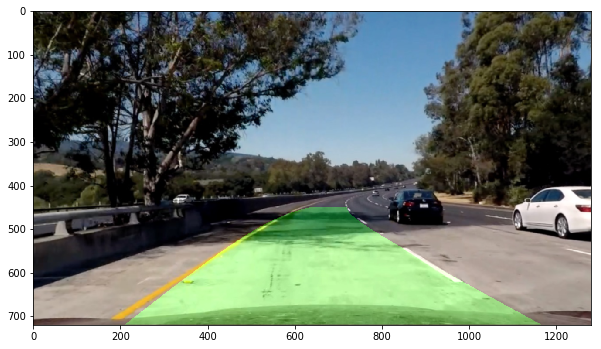

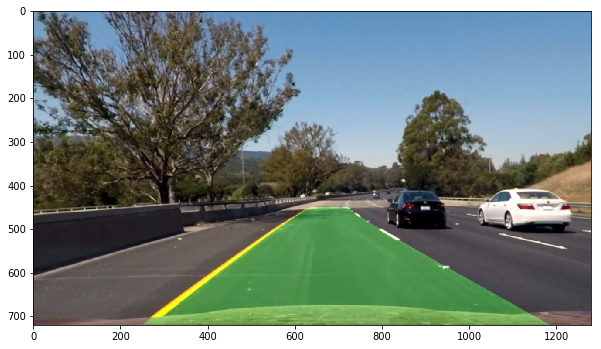

In [7]:
import os

test_img_path='./test_images/'
img_names=os.listdir(test_img_path)
for img_name in img_names:
    img=cv2.imread(test_img_path+img_name)
    img=cv2.GaussianBlur(img,(3,3),0)
    _,_,out=find_lanes(img)
    plt.figure(figsize=(10,10))
    plt.imshow(cv2.cvtColor(out,cv2.COLOR_BGR2RGB))

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
if not os.path.exists("test_videos_output"):
    os.makedirs("test_videos_output")

def process_frames(img):
    img=cv2.GaussianBlur(img,(3,3),0)
    _,_,out=find_lanes(img)
    return out

In [ ]:
white_output='test_videos_output/project_video.mp4'
clip1=VideoFileClip("./project_video.mp4")
white_clip=clip1.fl_image(process_frames) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)